In [201]:
import os
import torch.nn as nn
import numpy as np
from random import shuffle
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
from tqdm import tqdm
# from preprocess.focal_loss import FocalLoss
# from utils.svdd_loss import SVDDLoss
from dataloader.svdd_dataloader import CollisionLoader_audio as CollisionLoader_new
from nets.gaussianNet import GaussianSVDDModel 
from utils.reconstruction_loss import ReconstructionLoss_audio as ReconstructionLoss
%matplotlib inline
torch.manual_seed(42)
np.random.seed(42)

train_audio = '/home/iot/collision_detect/new_data/audio_np/Normal_test'
train_imu = '/home/iot/collision_detect/new_data/imu_np/Normal_test'

test_audio = '/home/iot/collision_detect/new_data/audio_np/Abnormal'
test_imu = '/home/iot/collision_detect/new_data/imu_np/Abnormal'

real_audio = '/home/iot/collision_detect/new_data/audio_np/Normal_train'
real_imu = '/home/iot/collision_detect/new_data/imu_np/Normal_train'




workers = 4
feature_dim = 32
batchsize = 64
use_attention = 1

checkpoint_path = f'/home/iot/GSVDD/output/test/model_14'
# checkpoint_path = f'/home/iot/collision_detect/output/Gaussian_audio/model_19'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
reconstruction_loss_fn = nn.SmoothL1Loss()
loss_function = nn.MSELoss()

real_data = CollisionLoader_new(real_imu,real_audio,train=True)
real_dataloader = DataLoader(real_data, batchsize, shuffle=True, num_workers=workers, drop_last=True)

train_data = CollisionLoader_new(train_imu,train_audio,train=True)
val_data   = CollisionLoader_new(test_imu,test_audio,train=False)
train_dataloader = DataLoader(train_data, batchsize, shuffle=True, num_workers=workers, drop_last=True)
val_dataloader   = DataLoader(val_data, batchsize, shuffle=True, num_workers=workers, drop_last=True)

# random_tensor = torch.load('/home/iot/collision_detect/svdd/center_2.pth').to(device)
# print(random_tensor.shape)
model = GaussianSVDDModel(output_dim=feature_dim,is_train=0).to(device)
model = model.to(device)
model.load_checkpoint(checkpoint_path)
# if checkpoint_path != '':
#     model.load_state_dict(torch.load(checkpoint_path))
#     print('Load weights')


cuda
Model loaded from /home/iot/GSVDD/output/test/model_14.


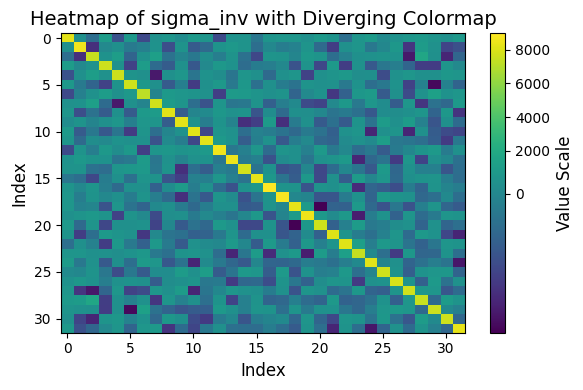

In [202]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import TwoSlopeNorm

# Assuming sigma_inv_matrix is your matrix
sigma_inv_matrix = (model.sigma_inv.cpu().numpy())

# Define the minimum, midpoint, and maximum for the color scale
vmin = np.min(sigma_inv_matrix)
vmax = np.max(sigma_inv_matrix)
midpoint = 100  # Set the midpoint to 0 for diverging visualization

# Use TwoSlopeNorm to create a custom normalization
norm = TwoSlopeNorm(vmin=vmin, vcenter=midpoint, vmax=vmax)

# Plot the heatmap with a diverging colormap
plt.figure(figsize=(6, 4))
im = plt.imshow(sigma_inv_matrix, cmap='viridis', norm=norm, aspect='auto')

# Add a color bar with a label
cbar = plt.colorbar(im)
cbar.set_label('Value Scale', fontsize=12)

# Add title and labels
plt.title('Heatmap of sigma_inv with Diverging Colormap', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Index', fontsize=12)
plt.tight_layout()
plt.show()


In [203]:
# import matplotlib.pyplot as plt

# # Initialize lists to store individual loss values
# reconstruction_losses_real = []
# svdd_losses_real = []
# total_losses_real = []
# total_z_real = []
# total_sample = 0
# # Iterate over the dataset to collect individual losses
# with torch.no_grad():
#     for sample_idx in range(len(real_data)):
#         spec, image, audio,_,_ = real_data[sample_idx]
#         spec, image, audio = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)
#         # print(image.shape,audio.shape,sample_idx)
#     # Forward pass through the model
#         anomaly_score, reconstructed_audio, reconstructed_imu,z= model(audio, image)

#         # Calculate reconstruction loss for the sample
#         reconstruction_loss = reconstruction_loss_fn( audio, reconstructed_audio) 
#         # reconstruction_loss = reconstruction_loss_fn( image, reconstructed_imu) * 10*334

#         # Calculate SVDD loss for the sample
#         svdd_loss = anomaly_score

#         # Calculate total loss for the sample
#         total_loss = svdd_loss + reconstruction_loss

#         # Append individual loss values to the lists
#         reconstruction_losses_real.append(reconstruction_loss.item())
#         svdd_losses_real.append(svdd_loss.item())
#         total_losses_real.append(total_loss.item())
#         total_z_real.append(z.squeeze().detach().cpu().numpy())
#         total_sample+=1

# # Plotting the data distribution of losses using scatter plots
# mean_reconstruction_loss = sum(reconstruction_losses_real) / len(reconstruction_losses_real)
# mean_svdd_loss = sum(svdd_losses_real) / len(svdd_losses_real)
# mean_total_loss = sum(total_losses_real) / len(total_losses_real)

# # Plotting the data distribution of losses using scatter plots
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 3, 1)
# plt.scatter(range(total_sample), reconstruction_losses_real, color='blue', alpha=0.5)
# plt.axhline(y=mean_reconstruction_loss, color='red', linestyle='--', label=f'Mean: {mean_reconstruction_loss:.2f}')
# plt.xlabel('Sample Index')
# plt.ylabel('Reconstruction Loss')
# plt.title('Reconstruction Loss Distribution')
# # plt.ylim(min(reconstruction_losses), 0.8)
# plt.legend()

# plt.subplot(1, 3, 2)
# plt.scatter(range(total_sample), svdd_losses_real, color='green', alpha=0.5)
# plt.axhline(y=mean_svdd_loss, color='red', linestyle='--', label=f'Mean: {mean_svdd_loss:.2f}')
# plt.xlabel('Sample Index')
# plt.ylabel('SVDD Loss')
# plt.title('SVDD Loss Distribution')
# # plt.ylim(min(svdd_losses_val), 0.32)
# plt.legend()

# plt.subplot(1, 3, 3)
# plt.scatter(range(total_sample), total_losses_real, color='orange', alpha=0.5)
# plt.axhline(y=mean_total_loss, color='red', linestyle='--', label=f'Mean: {mean_total_loss:.2f}')
# plt.xlabel('Sample Index')
# plt.ylabel('Total Loss')
# plt.title('Total Loss Distribution')
# # plt.ylim(min(total_losses),2)
# plt.legend()

# plt.tight_layout()
# plt.show()
# # mean_vector = np.mean(total_z_real, axis=0)
# # covariance_matrix =np.linalg.inv(np.cov(total_z_real, rowvar=False))
# # model.mu = torch.tensor(mean_vector).cuda().float()
# # model.sigma_inv = torch.tensor(covariance_matrix ).cuda().float()
# # # print(mean_vector,np.linalg.inv(covariance_matrix))
# # # plt.imshow(np.linalg.inv(covariance_matrix))

In [204]:
# svdd_losses_real = np.array(svdd_losses_real)  # Convert to NumPy array if not already
# num_elements = int(len(svdd_losses_real) * 0.9)  # Calculate the number of elements to keep
# indices = np.argsort(svdd_losses_real)[:num_elements]
# filtered_np_z_real = np_z_real[indices]


# real_means = np.mean(filtered_np_z_real, axis=0)
# real_stds = np.std(filtered_np_z_real, axis=0)
# # model.mu = torch.tensor(real_means).to(device)

In [205]:
# diagonal_values = np.diag(np.cov(total_z_real, rowvar=False))
# normalized_values = (diagonal_values - np.min(diagonal_values)) / (np.max(diagonal_values) - np.min(diagonal_values))

# # Create a column plot
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(normalized_values)), normalized_values, color='skyblue', edgecolor='black')

# # Add labels and title
# plt.title('Normalized Diagonal Values of sigma_inv', fontsize=14)
# plt.xlabel('Index', fontsize=12)
# plt.ylabel('Normalized Value', fontsize=12)
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()


In [206]:
# save_dir  = '/home/iot/collision_detect/svdd/ploting/signals/'
# imu_dir   = '/home/iot/collision_detect/new_data/imu_np/'
# audio_dir = '/home/iot/collision_detect/new_data/audio_np/'
# seq = 'wall'
# num = 50
# # sample_dir = f"Normal_test/{seq}/{num}.npy"
# sample_dir = f"Abnormal/{seq}/seq{num}.npy"
# x = np.load(os.path.join(imu_dir,sample_dir))
# y = np.load(os.path.join(audio_dir,sample_dir))
# tab_colors = plt.get_cmap('tab10').colors
# # Loop through each signal and plot it in a new figure
# # for i in range(3):
# plt.figure(figsize=(16, 4))
# # plt.figure()  # Create a new figure
# plt.plot(x[:, -1], color=tab_colors[1])  # Plot each signal (assuming x is a 2D array)
# # plt.ylim(0.5,1.5)
# plt.axis('off')  # Turn off the axes (including grid lines)
# plt.savefig(f'{save_dir}imu_{seq}_{num}.png', bbox_inches='tight', pad_inches=0, transparent=True)  # Save with transparent background
# plt.close()  # Close the figure to free up memory
# for i in range(2):
#     plt.figure(figsize=(16, 4))
#     # plt.figure()  # Create a new figure
#     plt.plot(y[i,:], color=tab_colors[0])  # Plot each signal (assuming x is a 2D array)
#     # plt.ylim(-0.1,0.1)
#     plt.axis('off')  # Turn off the axes (including grid lines)
#     plt.savefig(f'{save_dir}audio{i}_{seq}_{num}.png', bbox_inches='tight', pad_inches=0, transparent=True)  # Save with transparent background
#     plt.close()  # Close the figure to free up memory

In [207]:
# model.eval()
# sample_idx = 263# p
# # Assuming the necessary libraries and data are already imported and available in the current context

# # Your existing code to get the anomaly score, reconstructed audio, and reconstructed IMU
# spec, image, audio,_,_ = val_data[sample_idx]
# spec, image, audio = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)

# svdd_loss, reconstructed_audio, reconstructed_imu,_ = model(audio, image)
# reconstruction_loss = reconstruction_loss_fn(audio, reconstructed_audio)

# # target_zero = random_tensor.unsqueeze(0).expand(1, -1)
# # svdd_loss = loss_function(anomaly_score, target_zero)
# # total_loss = svdd_loss + reconstruction_loss

# # # Print the losses
# # print(f"Reconstruction Loss {reconstruction_loss.item():.4f}")
# # print(f"SVDD Loss for Sample: {svdd_loss.item():.4f}")

# # Prepare data for plotting
# original_audio = audio.cpu().detach().numpy().squeeze()[0]
# reconstructed_audio = reconstructed_audio.cpu().detach().numpy().squeeze()[0]

# original_imu = image.cpu().detach().numpy().squeeze()
# reconstructed_imu = reconstructed_imu.cpu().detach().numpy().squeeze()
# # Calculate errors
# audio_error = original_audio - reconstructed_audio
# imu_error = original_imu - reconstructed_imu

# # Plotting
# fig, axes = plt.subplots(4, 1, figsize=(12, 8))

# # Original and reconstructed audio signals
# axes[0].plot(original_audio, label='Original Audio')
# axes[0].plot(reconstructed_audio, label='Reconstructed Audio', linestyle='dashed')
# # axes[0].legend()
# # axes[0].set_title('Original and Reconstructed Audio')
# axes[0].set_ylim(-0.5, 0.5)

# # Error in audio signals
# axes[1].plot(audio_error, label='Audio Error', color='red',linestyle='dashed')
# # axes[1].legend()
# # axes[1].set_title('Audio Reconstruction Error')
# axes[1].set_ylim(-0.5, 0.5)

# # Original and reconstructed IMU signals
# axes[2].plot(original_imu, label='Original IMU')
# axes[2].plot(reconstructed_imu, label='Reconstructed IMU', linestyle='dashed')
# # axes[2].legend()
# # axes[2].set_title('Original and Reconstructed IMU')
# axes[2].set_ylim(0.5, 1.5)

# # Error in IMU signals
# axes[3].plot(imu_error, label='IMU Error', color='red', linestyle='dashed')
# # axes[3].legend()
# # axes[3].set_title('IMU Reconstruction Error')
# axes[3].set_ylim(-0.5, 0.5)

# plt.tight_layout()
# plt.show()



tensor([8.3158], device='cuda:0', grad_fn=<SqrtBackward0>)


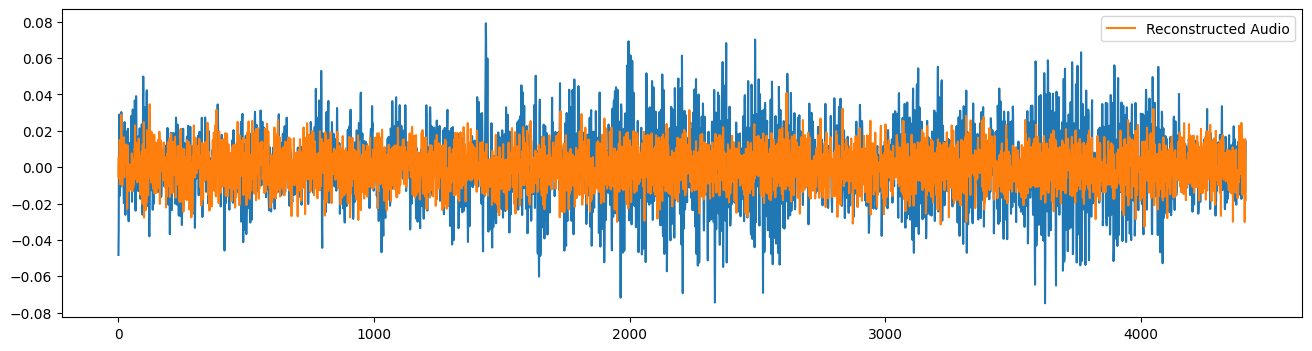

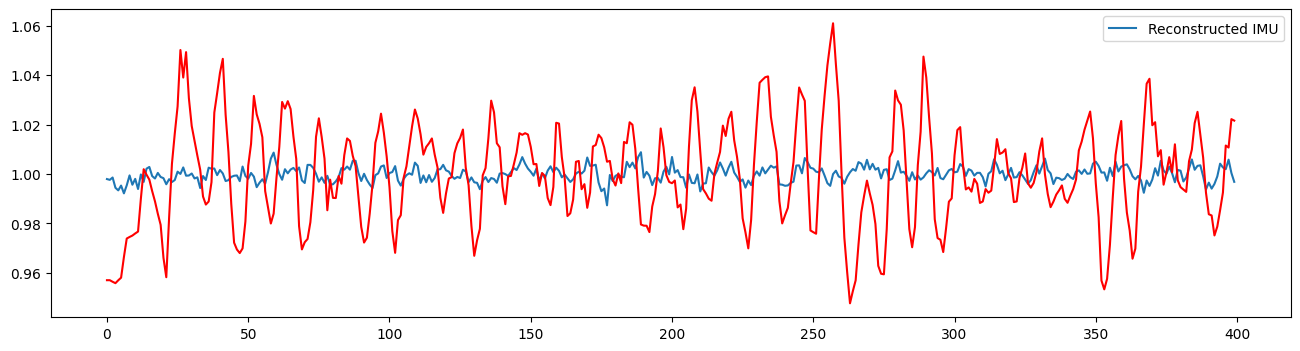

In [208]:
model.eval()
sample_idx = 94# print(audio.shape)5
# Change this to the index of the sample you want to load
spec, image, audio,_,_ = real_data[sample_idx]
spec, image, audio = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)

svdd_loss, reconstructed_audio, reconstructed_imu,_ = model(audio, image)
print(svdd_loss)
reconstruction_loss = reconstruction_loss_fn( audio, reconstructed_audio)
# target_zero = random_tensor.unsqueeze(0).expand(1, -1)
# svdd_loss = loss_function(anomaly_score, target_zero)
total_loss = svdd_loss+reconstruction_loss

# print(f"Reconstruction Loss {reconstruction_loss.item():.4f}")
# print(f"SVDd Loss for Sample: {svdd_loss.item():.4f}")
plt.figure(figsize=(16, 4))
plt.plot(audio.cpu().numpy().squeeze()[0])
plt.plot(reconstructed_audio.cpu().detach().numpy().squeeze()[0], label='Reconstructed Audio')
# plt.ylim(-0.4,0.4)
plt.legend()

plt.figure(figsize=(16, 4))
plt.plot(reconstructed_imu.cpu().detach().numpy().squeeze(), label='Reconstructed IMU')
plt.plot(image.cpu().numpy().squeeze(), 'r')
# plt.ylim(0.8,1.2)
plt.legend()


In [209]:
# model.mu = torch.tensor(mu).to(device).float()
# model.sigma_inv = torch.tensor(sigma_inv).to(device).float()
# model.eval()

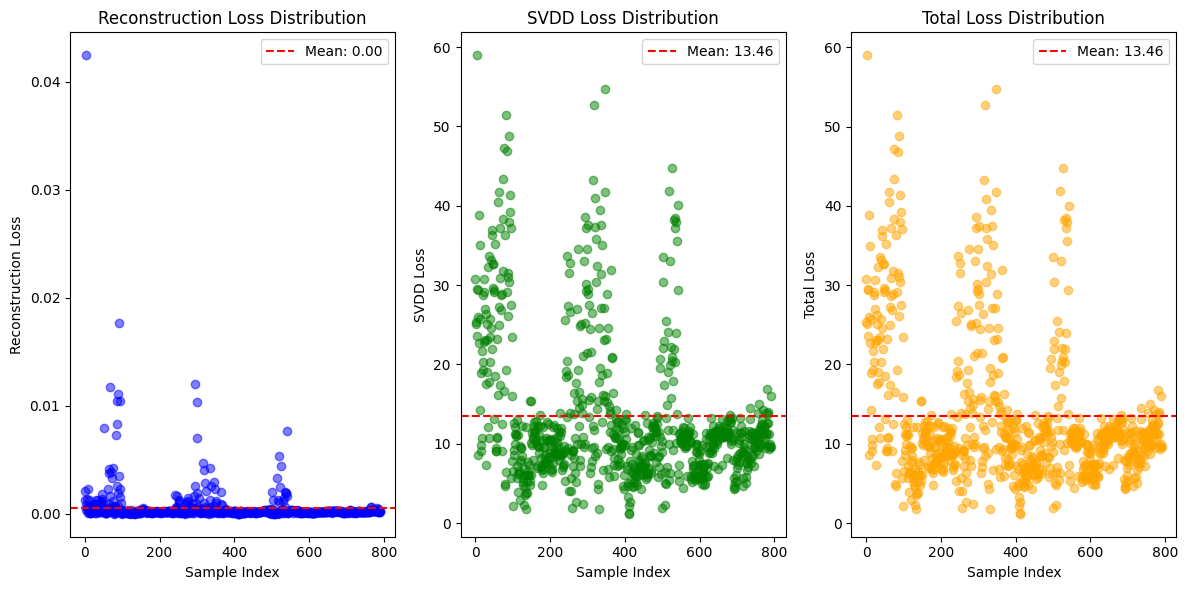

In [210]:
import matplotlib.pyplot as plt

# Initialize lists to store individual loss values
reconstruction_losses_val = []
svdd_losses_val = []
total_losses_val = []
total_z_val = []
total_sample = 0
# Iterate over the dataset to collect individual losses
with torch.no_grad():
    for sample_idx in range(len(val_data)):
        spec, image, audio,_,_ = val_data[sample_idx]
        spec, image, audio = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)
        # print(image.shape,audio.shape,sample_idx)
    # Forward pass through the model
        anomaly_score, reconstructed_audio, reconstructed_imu,z= model(audio, image)

        # Calculate reconstruction loss for the sample
        reconstruction_loss = reconstruction_loss_fn( audio, reconstructed_audio) 
        # reconstruction_loss = reconstruction_loss_fn( image, reconstructed_imu) * 10*334

        # Calculate SVDD loss for the sample
        svdd_loss = anomaly_score

        # Calculate total loss for the sample
        total_loss = svdd_loss + reconstruction_loss

        # Append individual loss values to the lists
        reconstruction_losses_val.append(reconstruction_loss.item())
        svdd_losses_val.append(svdd_loss.item())
        total_losses_val.append(total_loss.item())
        total_z_val.append(z.squeeze().detach().cpu().numpy())
        total_sample+=1

# Plotting the data distribution of losses using scatter plots
mean_reconstruction_loss = sum(reconstruction_losses_val) / len(reconstruction_losses_val)
mean_svdd_loss = sum(svdd_losses_val) / len(svdd_losses_val)
mean_total_loss = sum(total_losses_val) / len(total_losses_val)

# Plotting the data distribution of losses using scatter plots
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.scatter(range(total_sample), reconstruction_losses_val, color='blue', alpha=0.5)
plt.axhline(y=mean_reconstruction_loss, color='red', linestyle='--', label=f'Mean: {mean_reconstruction_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss Distribution')
# plt.ylim(min(reconstruction_losses), 0.8)
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(range(total_sample), svdd_losses_val, color='green', alpha=0.5)
plt.axhline(y=mean_svdd_loss, color='red', linestyle='--', label=f'Mean: {mean_svdd_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('SVDD Loss')
plt.title('SVDD Loss Distribution')
# plt.ylim(min(svdd_losses_val), 0.32)
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(range(total_sample), total_losses_val, color='orange', alpha=0.5)
plt.axhline(y=mean_total_loss, color='red', linestyle='--', label=f'Mean: {mean_total_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Total Loss')
plt.title('Total Loss Distribution')
# plt.ylim(min(total_losses),2)
plt.legend()

plt.tight_layout()
plt.show()

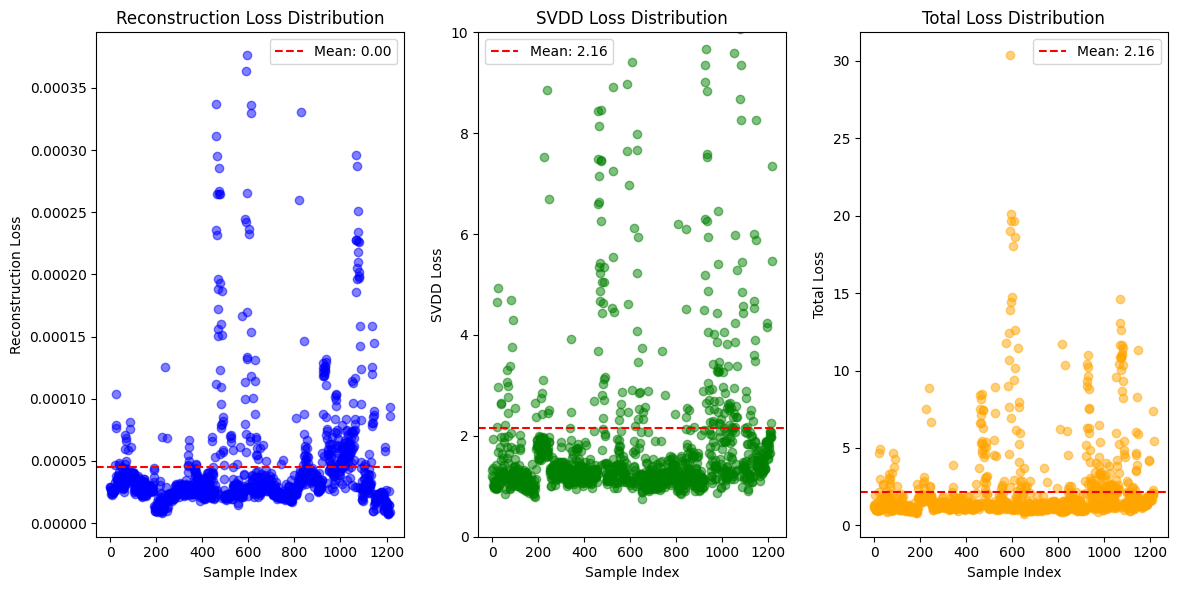

In [211]:
import matplotlib.pyplot as plt

# Initialize lists to store individual loss values
reconstruction_losses_train = []
svdd_losses_train = []
total_losses_train = []
total_z_train = []
# Iterate over the dataset to collect individual losses
with torch.no_grad():
    for sample_idx in range(len(train_data)):
        spec, image, audio,_,_ = train_data[sample_idx]
        spec, image, audio = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)
        # Forward pass through the model
        anomaly_score, reconstructed_audio, reconstructed_imu,z = model(audio, image)

        # Calculate reconstruction loss for the sample
        reconstruction_loss = reconstruction_loss_fn( audio, reconstructed_audio) 
        # reconstruction_loss = reconstruction_loss_fn( image, reconstructed_imu) * 10*334

        # Generate random tensor for SVDD loss
        # target_zero = random_tensor.unsqueeze(0).expand(spec.size(0), -1)

        # Calculate SVDD loss for the sample0
        svdd_loss = anomaly_score

        # Calculate total loss for the sample
        total_loss = svdd_loss + reconstruction_loss

        # Append individual loss values to the lists
        reconstruction_losses_train.append(reconstruction_loss.item())
        svdd_losses_train.append(svdd_loss.item())
        total_losses_train.append(total_loss.item())
        total_z_train.append(z.squeeze().detach().cpu().numpy())
        
# Plotting the data distribution of losses using scatter plots
mean_reconstruction_loss = sum(reconstruction_losses_train) / len(reconstruction_losses_train)
mean_svdd_loss = sum(svdd_losses_train) / len(svdd_losses_train)
mean_total_loss = sum(total_losses_train) / len(total_losses_train)

# Plotting the data distribution of losses using scatter plots
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.scatter(range(len(train_data)), reconstruction_losses_train, color='blue', alpha=0.5)
plt.axhline(y=mean_reconstruction_loss, color='red', linestyle='--', label=f'Mean: {mean_reconstruction_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss Distribution')
# plt.ylim(min(reconstruction_losses), max(reconstruction_losses)*1.1)
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(range(len(train_data)), svdd_losses_train, color='green', alpha=0.5)
plt.axhline(y=mean_svdd_loss, color='red', linestyle='--', label=f'Mean: {mean_svdd_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('SVDD Loss')
plt.title('SVDD Loss Distribution')
plt.ylim(0, 10)
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(range(len(train_data)), total_losses_train, color='orange', alpha=0.5)
plt.axhline(y=mean_total_loss, color='red', linestyle='--', label=f'Mean: {mean_total_loss:.2f}')
plt.xlabel('Sample Index')
plt.ylabel('Total Loss')
plt.title('Total Loss Distribution')
# plt.ylim(min(total_losses), max(total_losses)*1.1)
plt.legend()

plt.tight_layout()
plt.show()

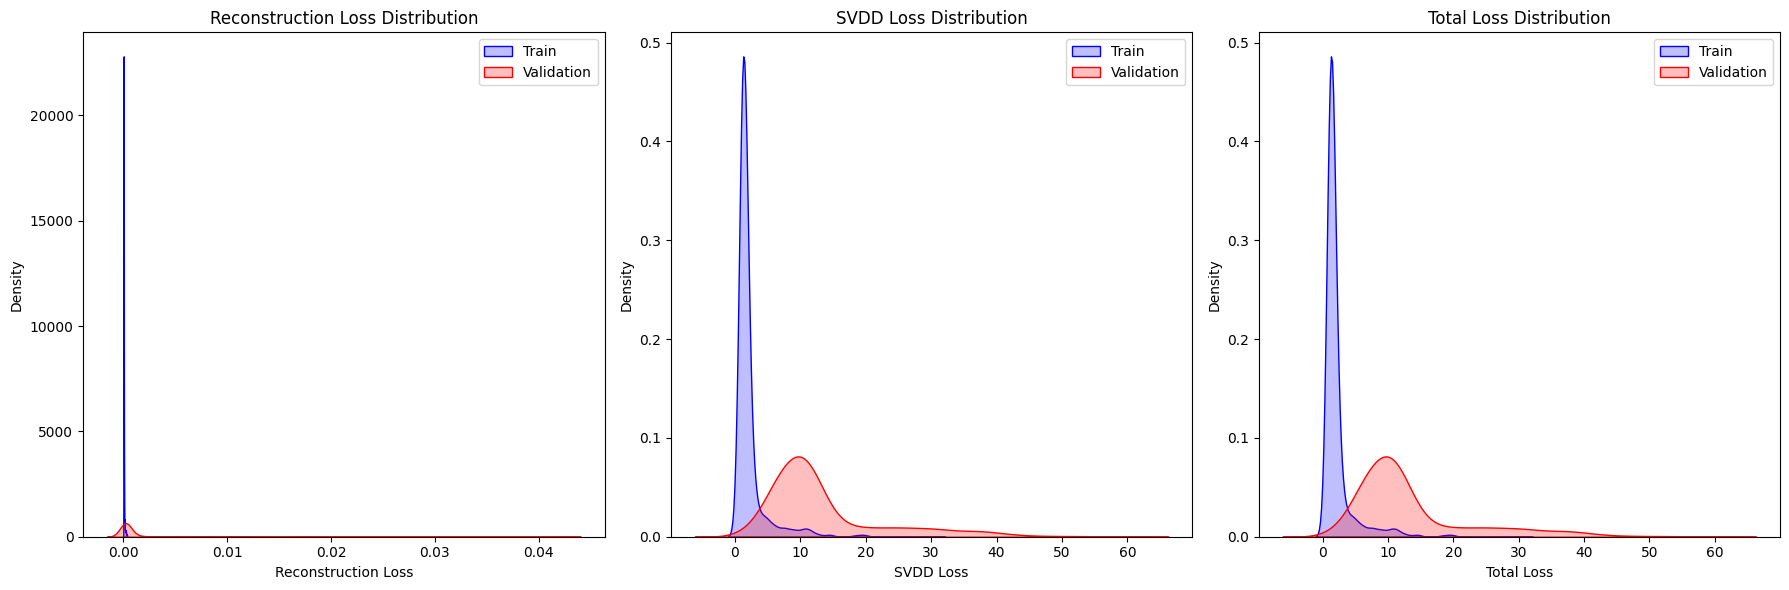

In [212]:
import seaborn as sns

# Plotting KDE plots
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.kdeplot(reconstruction_losses_train, color='blue', label='Train', fill=True)
sns.kdeplot(reconstruction_losses_val, color='red', label='Validation', fill=True)
plt.xlabel('Reconstruction Loss')
plt.ylabel('Density')
plt.title('Reconstruction Loss Distribution')
plt.legend()

plt.subplot(1, 3, 2)
sns.kdeplot(svdd_losses_train, color='blue', label='Train', fill=True)
sns.kdeplot(svdd_losses_val, color='red', label='Validation', fill=True)
plt.xlabel('SVDD Loss')
plt.ylabel('Density')
plt.title('SVDD Loss Distribution')
# plt.ylim(0, 1)
# plt.xlim(0, 40)
plt.legend()

plt.subplot(1, 3, 3)
sns.kdeplot(total_losses_train, color='blue', label='Train', fill=True)
sns.kdeplot(total_losses_val, color='red', label='Validation', fill=True)
plt.xlabel('Total Loss')
plt.ylabel('Density')
plt.title('Total Loss Distribution')
plt.legend()

plt.tight_layout()
plt.show()


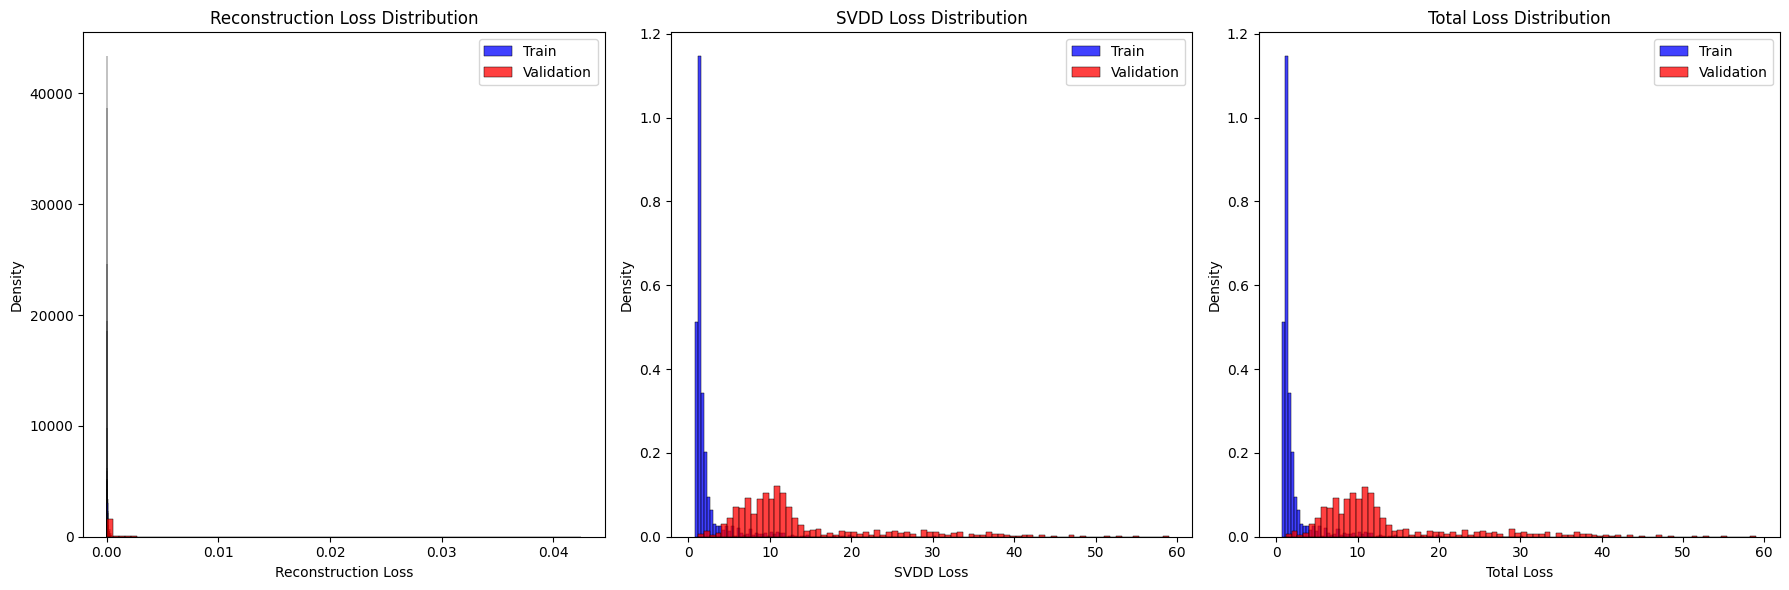

In [213]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting histograms
plt.figure(figsize=(18, 6))

# Plot for Reconstruction Loss Distribution
plt.subplot(1, 3, 1)
sns.histplot(reconstruction_losses_train, color='blue', label='Train', kde=False, bins=80, stat="density")
sns.histplot(reconstruction_losses_val, color='red', label='Validation', kde=False, bins=80, stat="density")
plt.xlabel('Reconstruction Loss')
plt.ylabel('Density')
plt.title('Reconstruction Loss Distribution')
plt.legend()

# Plot for SVDD Loss Distribution
plt.subplot(1, 3, 2)
sns.histplot(svdd_losses_train, color='blue', label='Train', kde=False, bins=80, stat="density")
sns.histplot(svdd_losses_val, color='red', label='Validation', kde=False, bins=80, stat="density")
plt.xlabel('SVDD Loss')
plt.ylabel('Density')
plt.title('SVDD Loss Distribution')
# plt.ylim(0, 1)
# plt.xlim(0, 0.4)
plt.legend()

# Plot for Total Loss Distribution
plt.subplot(1, 3, 3)
sns.histplot(total_losses_train, color='blue', label='Train', kde=False, bins=80, stat="density")
sns.histplot(total_losses_val, color='red', label='Validation', kde=False, bins=80, stat="density")
plt.xlabel('Total Loss')
plt.ylabel('Density')
plt.title('Total Loss Distribution')

plt.legend()

plt.tight_layout()
plt.show()


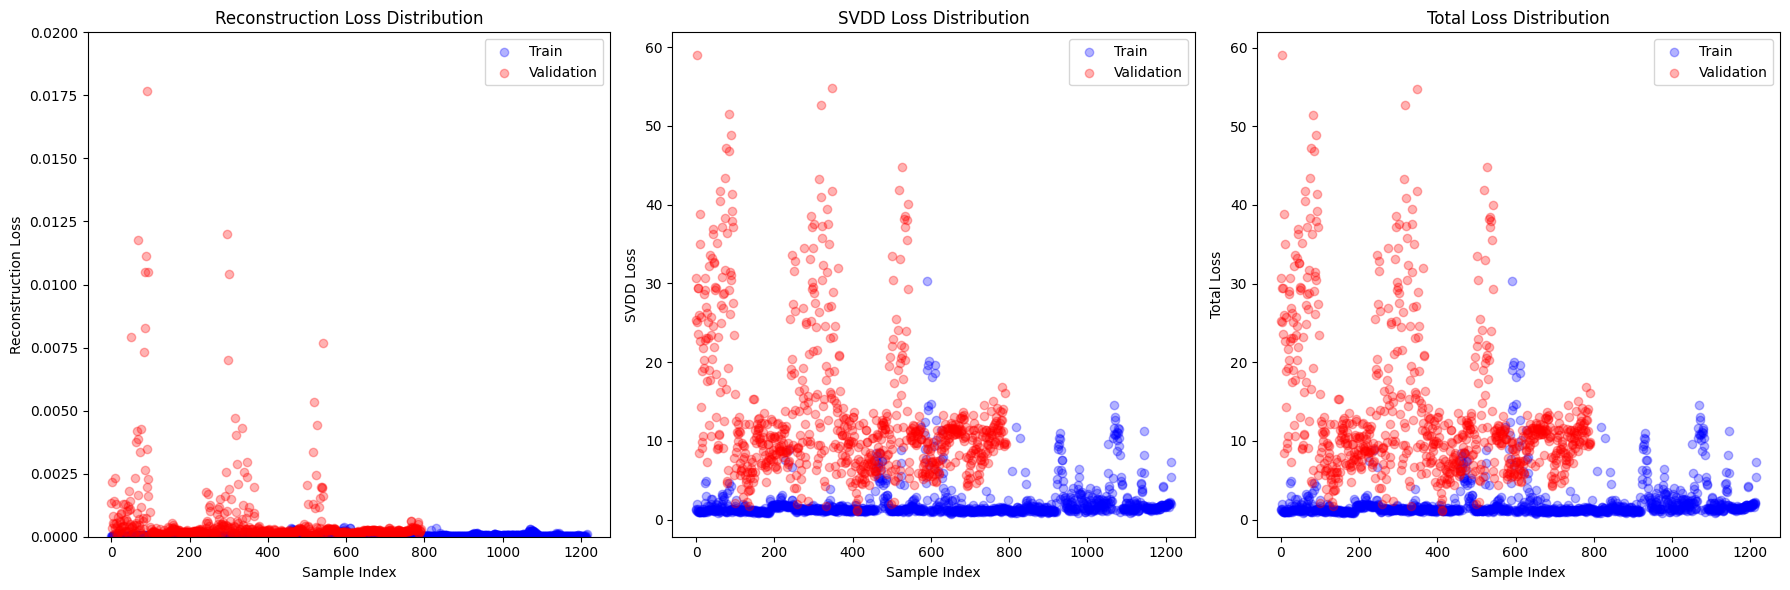

In [214]:
import matplotlib.pyplot as plt

# Plotting scatter plots
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.scatter(range(len(reconstruction_losses_train)), reconstruction_losses_train, color='blue', alpha=0.3, label='Train')
plt.scatter(range(len(reconstruction_losses_val)), reconstruction_losses_val, color='red', alpha=0.3, label='Validation')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Loss')
plt.title('Reconstruction Loss Distribution')
plt.ylim(0,0.02)
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(range(len(svdd_losses_train)), svdd_losses_train, color='blue', alpha=0.3, label='Train')
plt.scatter(range(len(svdd_losses_val)), svdd_losses_val, color='red', alpha=0.3, label='Validation')
plt.xlabel('Sample Index')
plt.ylabel('SVDD Loss')
# plt.ylim(0,0.3)
plt.title('SVDD Loss Distribution')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(range(len(total_losses_train)), total_losses_train, color='blue', alpha=0.3, label='Train')
plt.scatter(range(len(total_losses_val)), total_losses_val, color='red', alpha=0.3, label='Validation')
plt.xlabel('Sample Index')
plt.ylabel('Total Loss')
# plt.ylim(0.5,5)
plt.title('Total Loss Distribution')
plt.legend()

plt.tight_layout()
plt.show()


In [215]:
from deepod.metrics import ts_metrics
from deepod.metrics import point_adjustment 
def z_score_normalization(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    normalized_data = [(x - mean) / std_dev for x in data]
    return normalized_data


loss_all_audio = svdd_losses_train+svdd_losses_val
loss_all_audio = np.array(loss_all_audio)
# loss_all_audio = np.array(loss_all_audio)/np.mean(loss_all_audio)
# loss_all_audio = z_score_normalization(loss_all_audio)


loss_all_recons = reconstruction_losses_train+reconstruction_losses_val
loss_all_recons = np.array(loss_all_recons)
# loss_all_recons = np.array(loss_all_recons)/np.mean(loss_all_recons)
# loss_all_recons = z_score_normalization(loss_all_recons)

In [216]:
labels_all = np.concatenate([np.zeros(len(svdd_losses_train)),np.ones(len(svdd_losses_val))])
loss_all = [ x +3340*y for x, y in zip(loss_all_audio, loss_all_recons)]

eval_metrics_svdd = ts_metrics(labels_all, (loss_all_audio))
eval_metrics_recons = ts_metrics(labels_all, (loss_all_recons))
eval_metrics_all = ts_metrics(labels_all, (loss_all))

print(eval_metrics_svdd[:-2])
print(eval_metrics_recons[:-2])
print(eval_metrics_all[:-2])

(0.9680948049574696, 0.9355080183684701, 0.921765777959599, 0.8868144690781797, 0.9595959595959596)
(0.96365173112706, 0.9349190286996312, 0.9085278460774867, 0.8841099163679809, 0.9343434343434344)
(0.9685163726076554, 0.9371606516891169, 0.9204769382183652, 0.880184331797235, 0.9646464646464646)


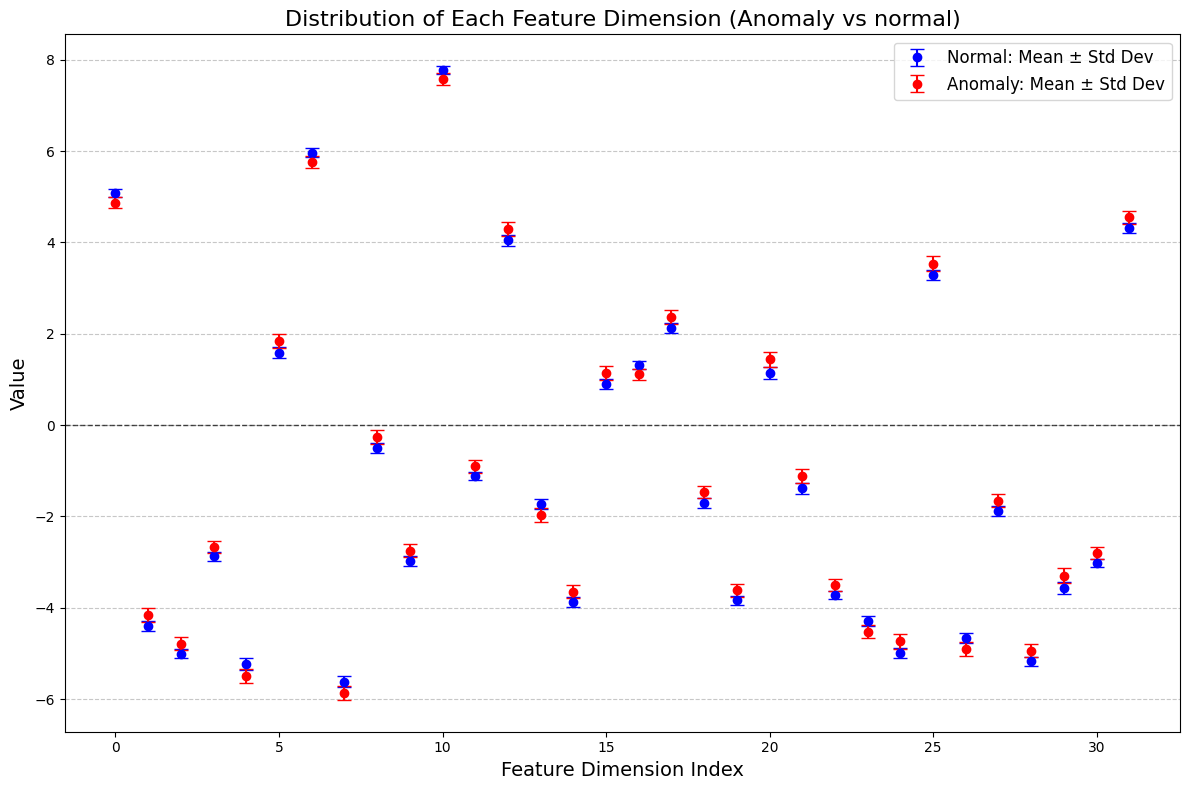

In [195]:
np_z_train = np.array(total_z_train)
np_z_val = np.array(total_z_val)
# np_z_real = np.array(total_z_real)

# svdd_losses_real = np.array(svdd_losses_real)  # Convert to NumPy array if not already
# num_elements = int(len(svdd_losses_real) * 0.95)  # Calculate the number of elements to keep
# indices = np.argsort(svdd_losses_real)[:num_elements]
# filtered_np_z_real = np_z_real[indices]


# real_means = np.mean(filtered_np_z_real, axis=0)
# real_stds = np.std(filtered_np_z_real, axis=0)

train_means = np.mean(np_z_train, axis=0)
train_stds = np.std(np_z_train, axis=0)

val_means = np.mean(np_z_val, axis=0)
val_stds = np.std(np_z_val, axis=0)

# Plot the mean and standard deviation
plt.figure(figsize=(12, 8))
x = np.arange(feature_dim)  # Feature indices

# Train set
plt.errorbar(
    x, train_means, yerr=train_stds, fmt='o', ecolor='blue', capsize=5, 
    label='Normal: Mean ± Std Dev', color='blue'
)

# Validation set
plt.errorbar(
    x, val_means, yerr=val_stds, fmt='o', ecolor='red', capsize=5, 
    label='Anomaly: Mean ± Std Dev', color='red'
)
# plt.errorbar(
#     x, real_means, yerr=real_stds, fmt='*', ecolor='orange', capsize=5, 
#     label='Real Mean ± Std Dev', color='orange'
# )
# Styling
plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)
plt.title('Distribution of Each Feature Dimension (Anomaly vs normal)', fontsize=16)
plt.xlabel('Feature Dimension Index', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()

# Show plot
plt.show()

In [196]:
# l2_dist_val_mean = np.sqrt(np.sum((np_z_val - real_means) ** 2, axis=1))  # Shape: (n,)
# l2_dist_train_mean = np.sqrt(np.sum((np_z_train - real_means) ** 2, axis=1))  # Shape: (n,)

In [197]:
# import matplotlib.pyplot as plt

# # Plotting scatter plots
# plt.figure(figsize=(18, 6))

# plt.subplot(1, 1, 1)
# plt.scatter(range(len(l2_dist_val_mean)), l2_dist_val_mean, color='blue', alpha=0.3, label='Train')
# plt.scatter(range(len(l2_dist_train_mean)), l2_dist_train_mean, color='red', alpha=0.3, label='Validation')
# plt.xlabel('Sample Index')
# plt.ylabel('Reconstruction Loss')
# plt.title('Reconstruction Loss Distribution')
# # plt.ylim(0,0.02)
# plt.legend()

# plt.tight_layout()
# plt.show()


In [198]:
# labels_all = np.concatenate([np.zeros(len(l2_dist_train_mean)),np.ones(len(l2_dist_val_mean))])
# loss_all = np.concatenate([l2_dist_train_mean,l2_dist_val_mean])
# eval_metrics_svdd = ts_metrics(labels_all, (loss_all))
# print(eval_metrics_svdd[:-2])

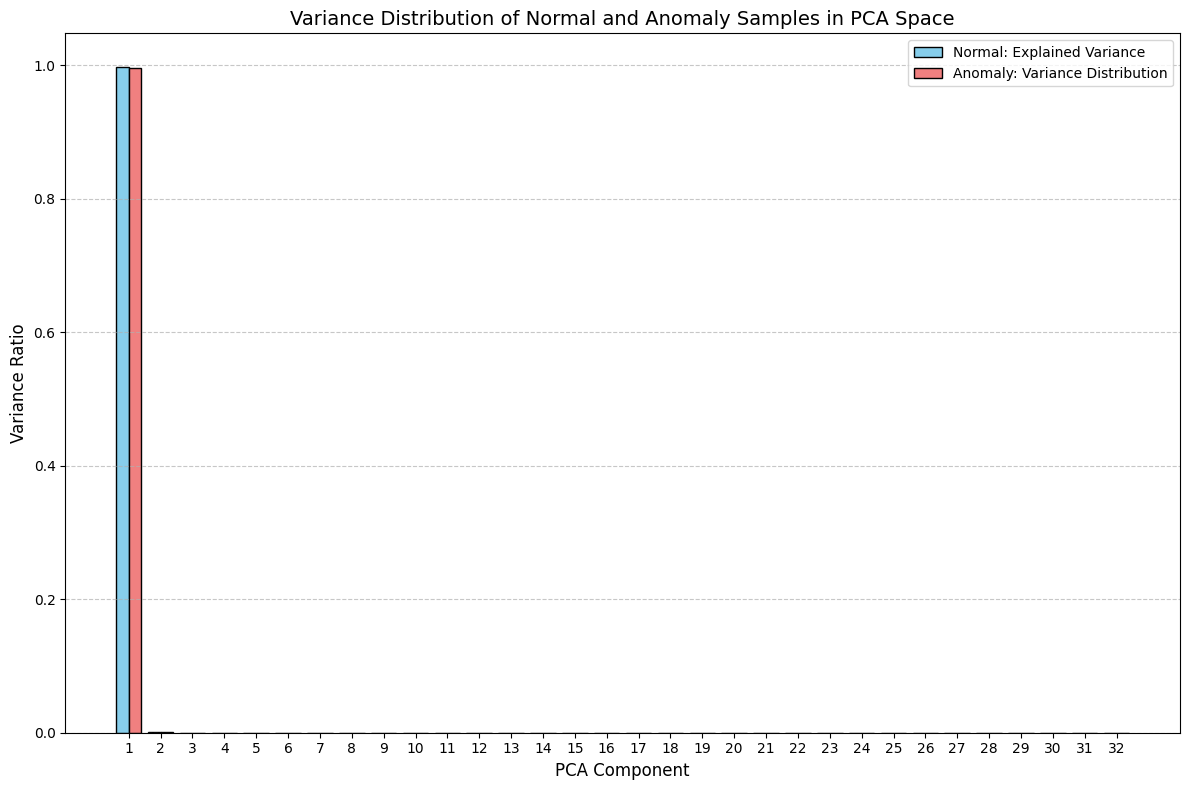

In [199]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming normal_features and anomaly_features are your input data
# Shapes: (n_normal, feature_dim) and (n_anomaly, feature_dim)
normal_features = total_z_train
anomaly_features = total_z_val

# Step 1: Fit PCA on normal features
pca = PCA(n_components=32)
pca.fit(normal_features)

# Step 2: Get the explained variance ratio for normal features
explained_variance_ratio = pca.explained_variance_ratio_

# Step 3: Transform both normal and anomaly features into the PCA space
normal_pca_projection = pca.transform(normal_features)
anomaly_pca_projection = pca.transform(anomaly_features)

# Step 4: Calculate variances for normal and anomaly projections in PCA space
normal_variances = np.var(normal_pca_projection, axis=0)
anomaly_variances = np.var(anomaly_pca_projection, axis=0)

# Step 5: Plot the explained variance and anomaly variances
plt.figure(figsize=(12, 8))

# Bar plot for normal feature explained variance
x = np.arange(1, len(explained_variance_ratio) + 1)  # Component indices
plt.bar(x - 0.2, explained_variance_ratio, width=0.4, color='skyblue', edgecolor='black', label='Normal: Explained Variance')

# Bar plot for anomaly feature variances
plt.bar(x + 0.2, anomaly_variances / np.sum(anomaly_variances), width=0.4, color='lightcoral', edgecolor='black', label='Anomaly: Variance Distribution')

# Add labels and title
plt.title("Variance Distribution of Normal and Anomaly Samples in PCA Space", fontsize=14)
plt.xlabel("PCA Component", fontsize=12)
plt.ylabel("Variance Ratio", fontsize=12)
plt.xticks(x)  # Ensure each component is labeled
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


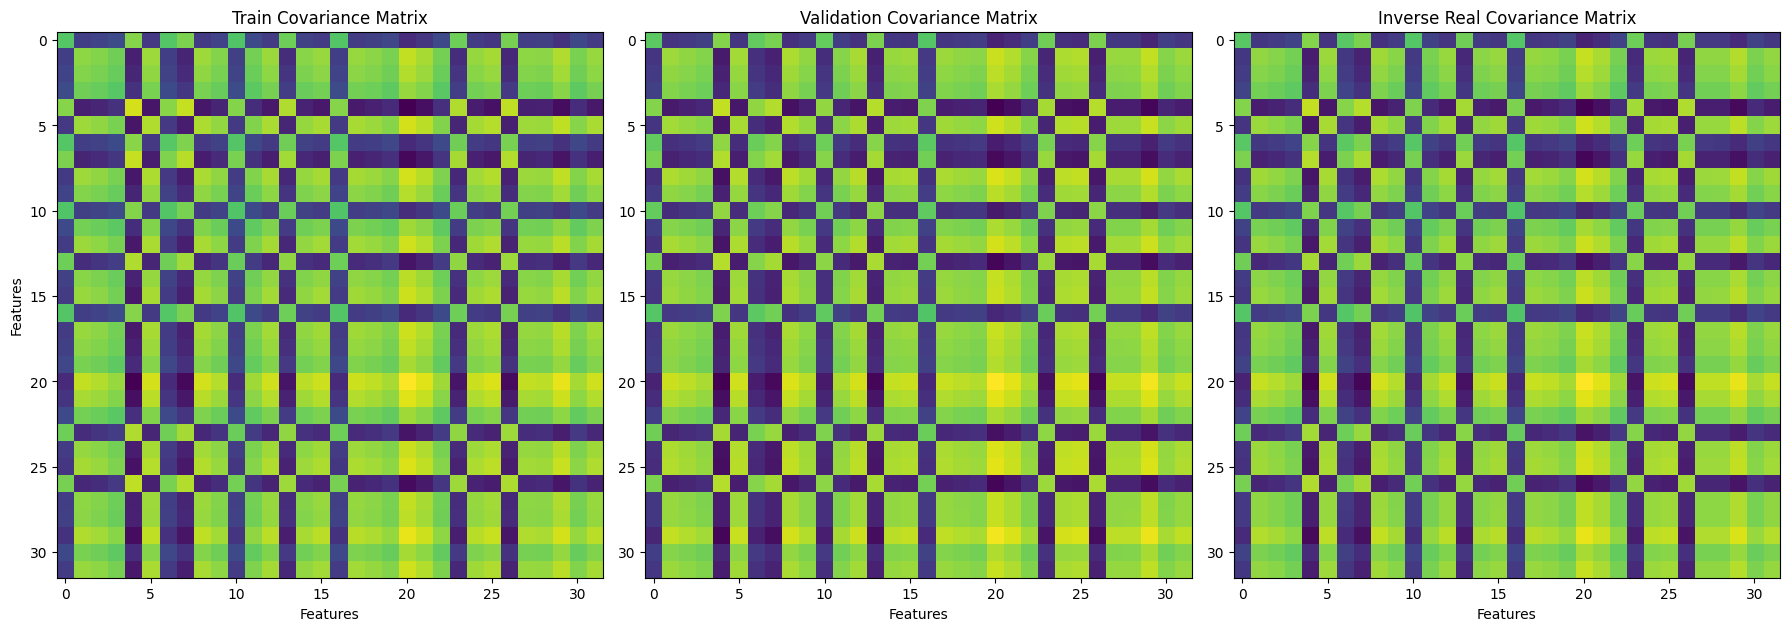

In [200]:
import numpy as np
import matplotlib.pyplot as plt

# Compute mean vectors and covariance matrices for train and validation sets
mean_vector_train = np.mean(total_z_train, axis=0)
covariance_matrix_train = np.cov(total_z_train, rowvar=False)

mean_vector_val = np.mean(total_z_val, axis=0)
covariance_matrix_val = np.cov(total_z_val, rowvar=False)

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Train covariance matrix
axs[0].imshow(covariance_matrix_train, cmap='viridis')
axs[0].set_title("Train Covariance Matrix")
axs[0].set_xlabel("Features")
axs[0].set_ylabel("Features")

# Validation covariance matrix
axs[1].imshow(covariance_matrix_val, cmap='viridis')
axs[1].set_title("Validation Covariance Matrix")
axs[1].set_xlabel("Features")

# Real (inverse covariance matrix)
axs[2].imshow(np.linalg.inv(sigma_inv_matrix), cmap='viridis')
axs[2].set_title("Inverse Real Covariance Matrix")
axs[2].set_xlabel("Features")

# # Add colorbars for each plot
# for ax in axs:
#     cbar = plt.colorbar(ax.images[0], ax=ax, orientation='vertical')
#     cbar.set_label("Value Scale")

# Adjust layout
plt.tight_layout()
plt.show()


In [160]:
# mean_vector = np.mean(total_z_real, axis=0)
# covariance_matrix = np.cov(total_z_real, rowvar=False)
# # print(mean_vector,np.linalg.inv(covariance_matrix))
# plt.imshow(np.linalg.inv(covariance_matrix))

In [161]:
from sklearn import metrics
precision, recall, thresholds= metrics.precision_recall_curve(labels_all, (loss_all_audio))
epsilon = 1e-10

f1_scores = 2 * (precision * recall) / (precision + recall + epsilon)
best_index = np.argmax(f1_scores)
best_threshold = thresholds[best_index]
print(best_threshold)

8.317353248596191


In [162]:
normal_list = train_data.audio_list
indoor_group = []
outdoor_group = []

for idx, filepath in enumerate(normal_list):
    parts = filepath.split('/')
    sequence = parts[-2]  # e.g., 'iseq2', 'iseq5', 'seq16'
    file_number = int(parts[-1].split('.')[0])  # Extract file number from filename (e.g., '0' from '0.npy')

    # Check if the file belongs to the indoor group (iseq2, iseq5, or seq16 with 0-104.npy)
    if sequence in ['iseq2', 'iseq5'] or (sequence == 'seq16' and  file_number >= 104):
        indoor_group.append(idx)  # Add the index of the file
    else:
        outdoor_group.append(idx)  # Add the index of the file
print(len(indoor_group),len(outdoor_group))
indoor_losses = [svdd_losses_train[idx] for idx in indoor_group]
outdoor_losses = [svdd_losses_train[idx] for idx in outdoor_group]

642 574


In [163]:
# Given threshold
threshold = best_threshold
# Example threshold, replace with actual value

# True labels for indoor and outdoor groups
true_labels_indoor = [0] * len(indoor_losses)  # All indoor samples are normal
true_labels_outdoor = [0] * len(outdoor_losses)  # All outdoor samples are anomalies

# Combine losses and true labels
all_losses = indoor_losses + outdoor_losses
all_true_labels = true_labels_indoor + true_labels_outdoor

# Calculate predicted labels based on the threshold
predicted_labels = [1 if score > threshold else 0 for score in all_losses]

# Calculate accuracy
correct_predictions = sum(pred == true for pred, true in zip(predicted_labels, all_true_labels))
total_samples = len(all_true_labels)
accuracy = correct_predictions / total_samples if total_samples > 0 else 0

# Output accuracy for both groups
print("Overall Accuracy:")
print(f"  Accuracy: {accuracy:.4f}")

# Optional: Calculate accuracy separately for indoor and outdoor groups
accuracy_indoor = sum(predicted_labels[i] == true_labels_indoor[i] for i in range(len(indoor_losses))) / len(indoor_losses) if len(indoor_losses) > 0 else 0
accuracy_outdoor = sum(predicted_labels[len(indoor_losses) + i] == true_labels_outdoor[i] for i in range(len(outdoor_losses))) / len(outdoor_losses) if len(outdoor_losses) > 0 else 0

print("\nIndoor Group Accuracy:")
print(f"  Accuracy: {accuracy_indoor:.4f}")

print("\nOutdoor Group Accuracy:")
print(f"  Accuracy: {accuracy_outdoor:.4f}")


Overall Accuracy:
  Accuracy: 0.9087

Indoor Group Accuracy:
  Accuracy: 0.8925

Outdoor Group Accuracy:
  Accuracy: 0.9268


In [134]:
abnormal_list = val_data.audio_list
mach_group = []
coli_group = []

for idx, filepath in enumerate(abnormal_list):
    parts = filepath.split('/')
    sequence = parts[-2]  # e.g., 'iseq2', 'iseq5', 'seq16'
    # file_number = int(parts[-1].split('.')[0])  # Extract file number from filename (e.g., '0' from '0.npy')

    # Check if the file belongs to the indoor group (iseq2, iseq5, or seq16 with 0-104.npy)
    if sequence in ['bl', 'br','fl','fr']:
        mach_group.append(idx)  # Add the index of the file
    else:
        coli_group.append(idx)  # Add the index of the file
        
mach_losses = [svdd_losses_val[idx] for idx in mach_group]
coli_losses = [svdd_losses_val[idx] for idx in coli_group]
print(len(mach_losses),len(coli_losses))

513 279


In [135]:
# Given threshold
threshold = best_threshold
# Example threshold, replace with actual value

# True labels for indoor and outdoor groups
true_labels_mach = [1] * len(mach_losses)  # All indoor samples are normal
true_labels_coli = [1] * len(coli_losses)  # All outdoor samples are anomalies

# Combine losses and true labels
all_losses = mach_losses + coli_losses
all_true_labels = true_labels_mach + true_labels_coli

# Calculate predicted labels based on the threshold
predicted_labels = [1 if score > threshold else 0 for score in all_losses]

# Calculate accuracy
correct_predictions = sum(pred == true for pred, true in zip(predicted_labels, all_true_labels))
total_samples = len(all_true_labels)
accuracy = correct_predictions / total_samples if total_samples > 0 else 0

# Output accuracy for both groups
print("Overall Accuracy:")
print(f"  Accuracy: {accuracy:.4f}")

# Optional: Calculate accuracy separately for indoor and outdoor groups
accuracy_mach = sum(predicted_labels[i] == true_labels_mach[i] for i in range(len(mach_losses))) / len(mach_losses) if len(mach_losses) > 0 else 0
accuracy_coli = sum(predicted_labels[len(mach_losses) + i] == true_labels_coli[i] for i in range(len(coli_losses))) / len(coli_losses) if len(outdoor_losses) > 0 else 0

print("\nmach Group Accuracy:")
print(f"  Accuracy: {accuracy_mach:.4f}")

print("\ncoli Group Accuracy:")
print(f"  Accuracy: {accuracy_coli:.4f}")


Overall Accuracy:
  Accuracy: 0.9470

mach Group Accuracy:
  Accuracy: 0.9552

coli Group Accuracy:
  Accuracy: 0.9319


In [146]:
target = '/home/iot/collision_detect/new_data/audio_np/Normal_test/seq15/18.npy'

# Find the index
try:
    index = audiolist.index(target)
    print(f"Element found at index: {index}")
    print(svdd_losses_train[index])
except ValueError:
    print("Element not found in the list.")

Element found at index: 90
2.7449400424957275


In [150]:
audiolist2 = val_data.audio_list

In [195]:
# for i in range(36):
target = f'/home/iot/collision_detect/new_data/audio_np/Abnormal/fr/10.npy'

# Find the index
try:
    index = audiolist2.index(target)
    print(f"Element found at index: {index}")
    print(svdd_losses_val[index])
except ValueError:
    print("Element not found in the list.")

Element found at index: 372
6.417201519012451


t-SNE completed in 1.34 seconds.


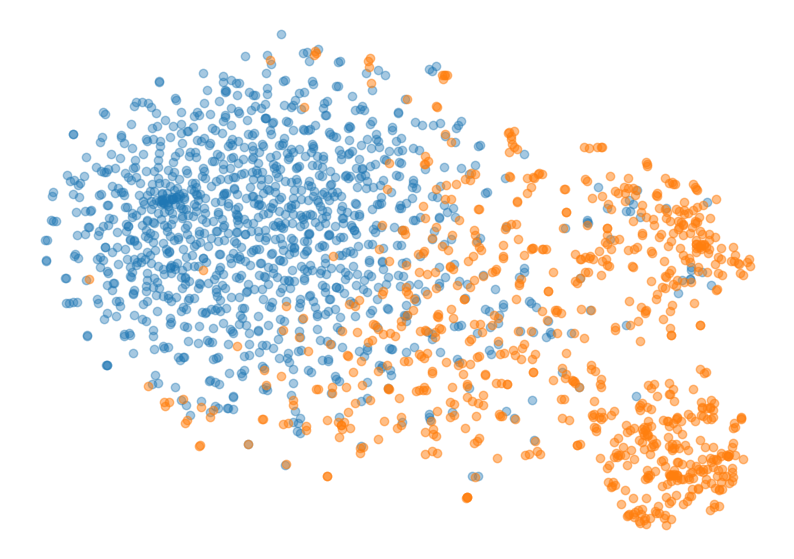

In [357]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import time

# Step 1: Convert your data to NumPy arrays
X_train = np.array(total_z_train)
X_test = np.array(total_z_val)

# Step 2: Combine train and test data for t-SNE
X_combined = np.vstack((X_train, X_test))

# Step 3: Start the timer for t-SNE
time_start = time.time()

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=0, n_iter=500)  # Adjust n_iter if necessary
X_tsne = tsne.fit_transform(X_combined)

# Calculate the time taken for t-SNE
time_end = time.time()
print(f"t-SNE completed in {time_end - time_start:.2f} seconds.")

# Step 4: Separate the t-SNE results back into train and test
X_train_tsne = X_tsne[:len(X_train)]
X_test_tsne = X_tsne[len(X_train):]

# Step 5: Plot the t-SNE results without axis and save with high resolution
plt.figure(figsize=(10, 7))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], alpha=0.4)
plt.scatter(X_test_tsne[:, 0], X_test_tsne[:, 1], alpha=0.5)

# Remove axis and legend (if you don't want it)
plt.axis('off')

# Save the figure with high resolution (300 DPI)
# plt.savefig('/home/iot/collision_detect/svdd/ploting/figures/tsne_plot_gsvdd2', dpi=500, bbox_inches='tight', pad_inches=0)

plt.show()


In [36]:
checkpoint = torch.load(checkpoint_path)
mu = checkpoint['mu'].cpu().numpy()
sigma_inv = checkpoint['sigma_inv'].cpu().numpy()
radius = checkpoint['radius'].detach().cpu().numpy()

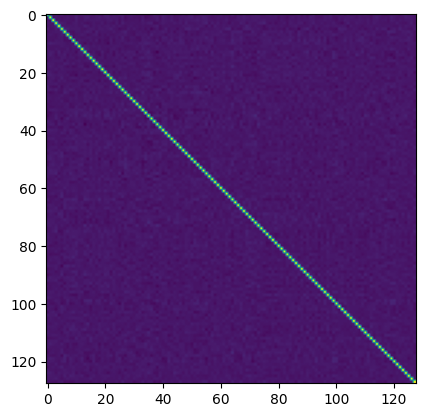

In [39]:
plt.imshow(sigma_inv)

In [40]:
sigma_inv

array([[952.39716  , -11.526943 ,   2.5224347, ...,   6.0722275,
          3.7388115,   3.3875296],
       [-11.526949 , 960.8441   , -21.334538 , ...,  10.473596 ,
          3.6756449,  -8.830197 ],
       [  2.5224357, -21.334545 , 974.70264  , ...,   6.121714 ,
          6.626605 ,  -9.72087  ],
       ...,
       [  6.0722346,  10.473594 ,   6.1217103, ..., 963.6304   ,
         -1.6082511,  13.7682495],
       [  3.7388134,   3.6756458,   6.6266084, ...,  -1.6082511,
        976.10205  ,  11.478389 ],
       [  3.3875268,  -8.830195 ,  -9.720871 , ...,  13.7682495,
         11.478388 , 957.6488   ]], dtype=float32)

In [359]:
mu[1] = mu[1]

In [360]:
tab_colors = plt.get_cmap('tab10').colors

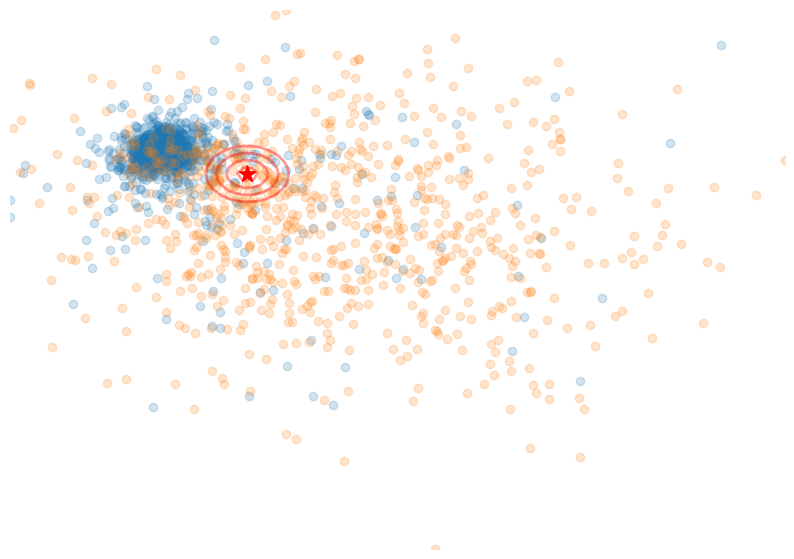

In [361]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

def plot_ellipsoid(mu, sigma_inv, X_train, X_test, mahalanobis_distances=[0.97, 2, 3,4], file_name='ellipsoid_plot.png'):
    """
    Plots the ellipsoid based on Mahalanobis distance, as well as X_train and X_test.
    
    Parameters:
    - mu: Mean vector.
    - sigma_inv: Inverse covariance matrix.
    - X_train: Training data.
    - X_test: Test data.
    - mahalanobis_distances: List of Mahalanobis distances to plot the ellipsoids for.
    - file_name: Name of the file to save the plot as a PNG.
    """
    
    # Step 1: Define a grid of points in the space of the first two features (for visualization)
    x_min, x_max = np.min(np.vstack((X_train, X_test))[:, 0]), np.max(np.vstack((X_train, X_test))[:, 0])
    y_min, y_max = np.min(np.vstack((X_train, X_test))[:, 1]), np.max(np.vstack((X_train, X_test))[:, 1])
    
    x, y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid_points = np.c_[x.ravel(), y.ravel()]

    # Step 2: Calculate Mahalanobis distance for each point in the grid
    mahalanobis_grid = []
    for point in grid_points:
        diff = point - mu[:2]
        mahalanobis_grid.append(np.sqrt(np.dot(np.dot(diff.T, sigma_inv[:2, :2]), diff)))

    mahalanobis_grid = np.array(mahalanobis_grid).reshape(x.shape)

    # Step 3: Plot the scatter plot of training and testing data
    plt.figure(figsize=(10, 7))

    # Default orange and blue colors for train and test
    plt.scatter(X_train[:, 0], X_train[:, 1], alpha=0.2,color=tab_colors[0])
    plt.scatter(X_test[:, 0], X_test[:, 1], alpha=0.2,color=tab_colors[1])


    # Step 4: Plot the ellipsoid contours for specified Mahalanobis distances
    for d in mahalanobis_distances:
        plt.contour(x, y, mahalanobis_grid, levels=[d], colors='r', alpha=0.4, linewidths=2)

    # Step 5: Plot the mean (center) of the ellipsoid
    plt.scatter(mu[0], mu[1], color='r', marker='*', s=150)

    # Step 6: Remove axis, legend, and title
    plt.axis('off')

    # Step 7: Save the plot as a high-resolution PNG
    # plt.savefig(file_name, bbox_inches='tight', pad_inches=0, dpi=300)
    # plt.close()

# Example usage

# Assuming mu, sigma_inv, X_train, and X_test are available as NumPy arrays
plot_ellipsoid(mu, sigma_inv, X_train, X_test, file_name='/home/iot/collision_detect/svdd/ploting/figures/ellipsoid_plot2.png')


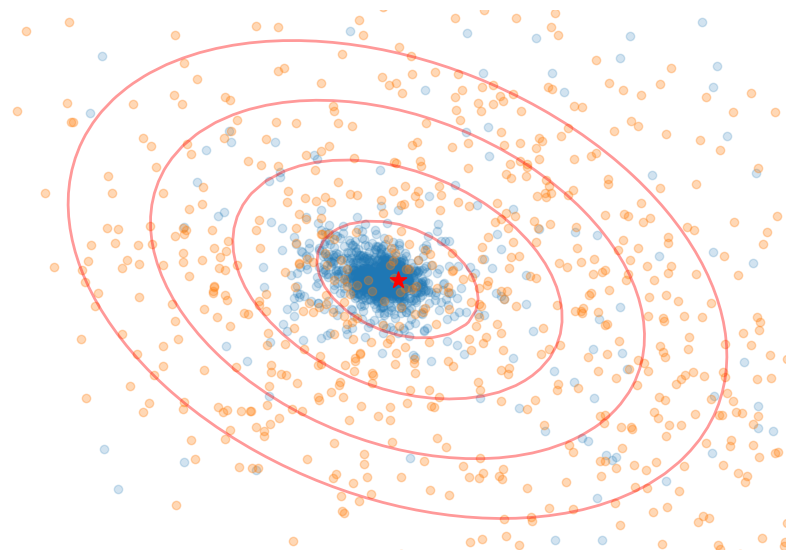

In [132]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance

def plot_ellipsoid(mu, sigma_inv, X_train, X_test, mahalanobis_distances=[0.98, 2, 3, 4], file_name='ellipsoid_plot.png'):
    """
    Plots the ellipsoid based on Mahalanobis distance, as well as X_train and X_test.
    
    Parameters:
    - mu: Mean vector.
    - sigma_inv: Inverse covariance matrix.
    - X_train: Training data.
    - X_test: Test data.
    - mahalanobis_distances: List of Mahalanobis distances to plot the ellipsoids for.
    - file_name: Name of the file to save the plot as a PNG.
    """
    
    # Step 1: Define a grid of points in the space of the first two features (for visualization)
    x_min, x_max = np.min(np.vstack((X_train, X_test))[:, 0]), np.max(np.vstack((X_train, X_test))[:, 0])
    y_min, y_max = np.min(np.vstack((X_train, X_test))[:, 1]), np.max(np.vstack((X_train, X_test))[:, 1])
    
    x, y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid_points = np.c_[x.ravel(), y.ravel()]

    # Step 2: Calculate Mahalanobis distance for each point in the grid
    mahalanobis_grid = []
    for point in grid_points:
        diff = point - mu[:2]
        mahalanobis_grid.append(np.sqrt(np.dot(np.dot(diff.T, sigma_inv[:2, :2]), diff)))

    mahalanobis_grid = np.array(mahalanobis_grid).reshape(x.shape)

    # Step 3: Plot the scatter plot of training and testing data
    plt.figure(figsize=(10, 7))

    # Default orange and blue colors for train and test
    plt.scatter(X_train[:, 0], X_train[:, 1], alpha=0.2, color=tab_colors[0])
    plt.scatter(X_test[:, 0], X_test[:, 1], alpha=0.3, color=tab_colors[1])

    # Step 4: Plot the ellipsoid contours for specified Mahalanobis distances
    for d in mahalanobis_distances:
        plt.contour(x, y, mahalanobis_grid, levels=[d], colors='r', alpha=0.4, linewidths=2)

    # Step 5: Plot the mean (center) of the ellipsoid
    plt.scatter(mu[0], mu[1], color='r', marker='*', s=150)

    # Step 6: Automatically set axis limits based on the max Mahalanobis distance
    max_distance = np.max(mahalanobis_distances) /9
    plt.xlim(mu[0] - max_distance, mu[0] + max_distance)
    plt.ylim(mu[1] - max_distance, mu[1] + max_distance)

    # Step 7: Remove axis, legend, and title
    plt.axis('off')

    # Step 8: Save the plot as a high-resolution PNG
    plt.savefig(file_name, bbox_inches='tight', pad_inches=0, dpi=300)
    # plt.close()

# Example usage
# Assuming mu, sigma_inv, X_train, and X_test are available as NumPy arrays
plot_ellipsoid(mu, sigma_inv, X_train, X_test, file_name='/home/iot/collision_detect/svdd/ploting/figures/ellipsoid_plot3.png')


In [158]:
from deepod.metrics import ts_metrics
from deepod.metrics import point_adjustment 
def z_score_normalization(data):
    mean = np.mean(data)
    std_dev = np.std(data)
    normalized_data = [(x - mean) / std_dev for x in data]
    return normalized_data

def z_score_normalization2(data):
    normalized_data = data-min(data)/(max(data)-min(data))
    return normalized_data


loss_all_audio = svdd_losses_train+svdd_losses_val
w2 = []
for loss in loss_all_audio:
    if loss > 1.75:
        w = 0
    else:
        w = 0.5
    w2.append(w)

# Compute w1 as the complement of w2
w1 = [1 - w for w in w2]
loss_all_audio = np.array(loss_all_audio)
loss_all_audio = z_score_normalization(loss_all_audio)


loss_all_recons = reconstruction_losses_train+reconstruction_losses_val
loss_all_recons = np.array(loss_all_recons)
loss_all_recons = z_score_normalization(loss_all_recons)

In [162]:
# labels_all = np.concatenate([np.zeros(len(svdd_losses_train)),np.ones(len(svdd_losses_val))])
# loss_all = [0.5*x + 0.5*y for x, y in zip(loss_all_audio, loss_all_recons)]


In [193]:
labels_all = np.concatenate([np.zeros(len(svdd_losses_train)),np.ones(len(svdd_losses_val))])
loss_all = [ x +3340*y for w1_i, w2_i, x, y in zip(w1, w2, loss_all_audio, loss_all_recons)]

In [194]:
eval_metrics_svdd = ts_metrics(labels_all, (loss_all_audio))
eval_metrics_recons = ts_metrics(labels_all, (loss_all_recons))
eval_metrics_all = ts_metrics(labels_all, (loss_all))

In [195]:
print(eval_metrics_svdd[:-2])
print(eval_metrics_recons[:-2])
print(eval_metrics_all[:-2])

(0.9686108619085593, 0.9390064502191986, 0.9153324273222365, 0.8902147971360382, 0.9419191919191919)
(0.9626974930223285, 0.9333016897858242, 0.9068577494508185, 0.8809523809523809, 0.9343434343434344)
(0.9674717985778841, 0.9391164709677542, 0.9116865434298002, 0.8982843137254902, 0.9255050505050505)


In [175]:
# x = np.load('/home/iot/collision_detect/OmniAnomaly/processed/SMAP_test.pkl',allow_pickle=True)

In [36]:
# from sklearn.metrics import confusion_matrix
# import numpy as np
# model.eval()
# random_tensor = torch.load('center.pth').to(device)
# true_labels = []
# predicted_labels = []
# threshold = 0.45

# with torch.no_grad():
#     for sample_idx in range(len(val_data)):
#         spec, image, audio = val_data[sample_idx]

#         spec, image, audio = spec.unsqueeze(0).to(device), image.unsqueeze(0).to(device), audio.unsqueeze(0).to(device)

#         anomaly_score, reconstructed_audio, reconstructed_imu = model(audio, image)

#         reconstruction_loss = reconstruction_loss_fn(image, reconstructed_imu, audio, reconstructed_audio) * 10

#         target_zero = random_tensor.unsqueeze(0).expand(spec.size(0), -1)

#         # Calculate SVDD loss for the sample
#         svdd_loss = loss_function(anomaly_score, target_zero)*100

#         # Calculate total loss for the sample
#         total_loss = svdd_loss + reconstruction_loss

#         # Predict class based on total loss
#         if svdd_loss<=mean_svdd_loss:
#             predicted_class=0
#         else:
#             predicted_class=1

#         # Handle ground truth class
#         true_class = 1

#         # Update confusion matrix variables
#         true_labels.append(true_class)
#         predicted_labels.append(predicted_class)

# # Construct confusion matrix
# conf_matrix = confusion_matrix(true_labels, predicted_labels)

# print("Confusion Matrix:")
# print(conf_matrix)


In [19]:
import torch.nn as nn
import torch.nn.functional as F
import torch
# from svdd_detectnet import DetectNet
import torch.nn.functional as F
import importlib
import torch
import numpy as np
from torch.nn.utils import weight_norm


def _handle_n_hidden(n_hidden):
    if type(n_hidden) == int:
        n_layers = 1
        hidden_dim = n_hidden
    elif type(n_hidden) == str:
        n_hidden = n_hidden.split(',')
        n_hidden = [int(a) for a in n_hidden]
        n_layers = len(n_hidden)
        hidden_dim = int(n_hidden[0])

    else:
        raise TypeError('n_hidden should be a string or a int.')

    return hidden_dim, n_layers

def _instantiate_class(module_name: str, class_name: str):
    module = importlib.import_module(module_name)
    class_ = getattr(module, class_name)
    return class_()

class ConvSeqEncoder(torch.nn.Module):
    """
    this network architecture is from NeurTraL-AD
    """
    def __init__(self, n_features, n_hidden='100', n_output=128, n_layers=3, seq_len=100,
                 bias=True, batch_norm=True, activation='ReLU'):
        super(ConvSeqEncoder, self).__init__()

        n_hidden, _ = _handle_n_hidden(n_hidden)

        self.bias = bias
        self.batch_norm = batch_norm
        self.activation = activation

        enc = [self._make_layer(n_features, n_hidden, (3,1,1))]
        in_dim = n_hidden
        window_size = seq_len
        for i in range(n_layers - 2):
            out_dim = n_hidden*2**i
            enc.append(self._make_layer(in_dim, out_dim, (3,2,1)))
            in_dim =out_dim
            window_size = np.floor((window_size+2-3)/2)+1

        self.enc = torch.nn.Sequential(*enc)
        self.final_layer = torch.nn.Conv1d(in_dim, n_output, int(window_size), 1, 0)

    def _make_layer(self, in_dim, out_dim, conv_param):
        down_sample = None
        if conv_param is not None:
            down_sample = torch.nn.Conv1d(in_channels=in_dim, out_channels=out_dim,
                                          kernel_size=conv_param[0], stride=conv_param[1], padding=conv_param[2],
                                          bias=self.bias)
        elif in_dim != out_dim:
            down_sample = torch.nn.Conv1d(in_channels=in_dim, out_channels=out_dim,
                                          kernel_size=1, stride=1, padding=0,
                                          bias=self.bias)

        layer = ConvResBlock(in_dim, out_dim, conv_param, down_sample=down_sample,
                             batch_norm=self.batch_norm, bias=self.bias, activation=self.activation)

        return layer

    def forward(self, x):
        x = x.permute(0, 2, 1)
        z = self.enc(x)
        z = self.final_layer(z)
        return z.squeeze(-1)


class ConvResBlock(torch.nn.Module):
    """Convolutional Residual Block"""
    def __init__(self, in_dim, out_dim, conv_param=None, down_sample=None,
                 batch_norm=False, bias=False, activation='ReLU'):
        super(ConvResBlock, self).__init__()

        self.conv1 = torch.nn.Conv1d(in_dim, in_dim,
                                     kernel_size=1, stride=1, padding=0, bias=bias)

        if conv_param is not None:
            self.conv2 = torch.nn.Conv1d(in_dim, in_dim,
                                         conv_param[0], conv_param[1], conv_param[2],bias=bias)
        else:
            self.conv2 = torch.nn.Conv1d(in_dim, in_dim,
                                         kernel_size=3, stride=1, padding=1, bias=bias)

        self.conv3 = torch.nn.Conv1d(in_dim, out_dim,
                                     kernel_size=1, stride=1, padding=0, bias=bias)

        if batch_norm:
            self.bn1 = torch.nn.BatchNorm1d(in_dim)
            self.bn2 = torch.nn.BatchNorm1d(in_dim)
            self.bn3 = torch.nn.BatchNorm1d(out_dim)
            if down_sample:
                self.bn4 = torch.nn.BatchNorm1d(out_dim)

        self.act = _instantiate_class("torch.nn.modules.activation", activation)
        self.down_sample = down_sample
        self.batch_norm = batch_norm

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        if self.batch_norm:
            out = self.bn1(out)
        out = self.act(out)

        out = self.conv2(out)
        if self.batch_norm:
            out = self.bn2(out)
        out = self.act(out)

        out = self.conv3(out)
        if self.batch_norm:
            out = self.bn3(out)

        if self.down_sample is not None:
            residual = self.down_sample(x)
            if self.batch_norm:
                residual = self.bn4(residual)

        out += residual
        out = self.act(out)

        return out

class ConvSeqDecoder(nn.Module):
    """
    Decoder architecture for ConvSeqEncoder, which reconstructs the input sequence
    from the encoded latent space representation.
    """
    def __init__(self, n_features, n_hidden='100', n_output=128, n_layers=3, seq_len=100,
                 bias=True, batch_norm=True, activation='ReLU'):
        super(ConvSeqDecoder, self).__init__()

        n_hidden, _ = _handle_n_hidden(n_hidden)

        self.bias = bias
        self.batch_norm = batch_norm
        self.activation = activation

        dec = []

        # Calculate the initial dimensions and window size for the first layer of the decoder
        in_dim = n_output  # This should match the output channels of the encoder
        window_size = seq_len

        for i in range(n_layers - 2):
            out_dim = n_hidden * 2 ** (n_layers - i - 3)
            dec.append(self._make_layer(in_dim, out_dim, (3, 2, 1)))
            in_dim = out_dim
            window_size = np.ceil((window_size - 1) * 2 - 2)

        # Add the final layer to reconstruct to the original input features
        self.dec = nn.Sequential(*dec)
        self.final_layer = nn.ConvTranspose1d(in_dim, n_features, kernel_size=(3,), stride=(1,), padding=(1,))

    def _make_layer(self, in_dim, out_dim, conv_param):
        up_sample = nn.ConvTranspose1d(
            in_channels=in_dim, out_channels=out_dim,
            kernel_size=conv_param[0], stride=conv_param[1], padding=conv_param[2],
            bias=self.bias
        )
        layer = ConvResBlock(in_dim, out_dim, conv_param, down_sample=up_sample,
                             batch_norm=self.batch_norm, bias=self.bias, activation=self.activation)

        return layer

    def forward(self, x):
        # Input is expected to be (batch_size, channels, sequence_length)
        z = self.dec(x)
        z = self.final_layer(z)
        return z

# Define Autoencoder Class
class ConvSeqAutoencoder(nn.Module):
    def __init__(self, n_features, n_hidden='100', n_output=128, n_layers=3, seq_len=100,
                 bias=True, batch_norm=True, activation='ReLU'):
        super(ConvSeqAutoencoder, self).__init__()
        self.encoder = ConvSeqEncoder(n_features, n_hidden, n_output, n_layers, seq_len, bias, batch_norm, activation)
        self.decoder = ConvSeqDecoder(n_features, n_hidden, n_output, n_layers, seq_len, bias, batch_norm, activation)

    def forward(self, x):
        # Expecting input shape to be (batch_size, seq_len, n_features)
        # Permute to (batch_size, n_features, seq_len) for Conv1d

        encoded = self.encoder(x)
        # x = x.permute(0, 2, 1)
        print(x.shape)
        decoded = self.decoder(encoded)
        # Permute back to original input shape
        decoded = decoded.permute(0, 2, 1)
        return decoded

# Example Usage
if __name__ == "__main__":
    # Hyperparameters
    seq_len = 100
    n_features = 16
    batch_size = 8

    # Initialize the model
    autoencoder = ConvSeqAutoencoder(n_features=n_features, seq_len=seq_len)

    # Example input (batch_size, seq_len, n_features)
    input_data = torch.randn(batch_size, seq_len, n_features)  # Random synthetic data

    # Forward pass
    reconstructed_data = autoencoder(input_data)

    # Print the shapes to verify
    print(f"Input data shape: {input_data.shape}")
    print(f"Reconstructed data shape: {reconstructed_data.shape}")




torch.Size([8, 100, 16])


RuntimeError: Given groups=1, weight of size [128, 128, 1], expected input[1, 8, 128] to have 128 channels, but got 8 channels instead

In [362]:
model = ConvSeqEncoder(n_features=33, n_hidden='512', n_layers=4, seq_len=100, batch_norm=False,
                       n_output=1, activation='LeakyReLU')
print(model)
a = torch.randn(32, 100, 33)

b =  model(a)
print(b.shape)

ConvSeqEncoder(
  (enc): Sequential(
    (0): ConvResBlock(
      (conv1): Conv1d(33, 33, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(33, 33, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv3): Conv1d(33, 512, kernel_size=(1,), stride=(1,))
      (act): LeakyReLU(negative_slope=0.01)
      (down_sample): Conv1d(33, 512, kernel_size=(3,), stride=(1,), padding=(1,))
    )
    (1): ConvResBlock(
      (conv1): Conv1d(512, 512, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
      (conv3): Conv1d(512, 512, kernel_size=(1,), stride=(1,))
      (act): LeakyReLU(negative_slope=0.01)
      (down_sample): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
    )
    (2): ConvResBlock(
      (conv1): Conv1d(512, 512, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
      (conv3): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
      (act): LeakyReLU(n

In [10]:
conf_matrix = np.array([[267, 105],[48, 278]])

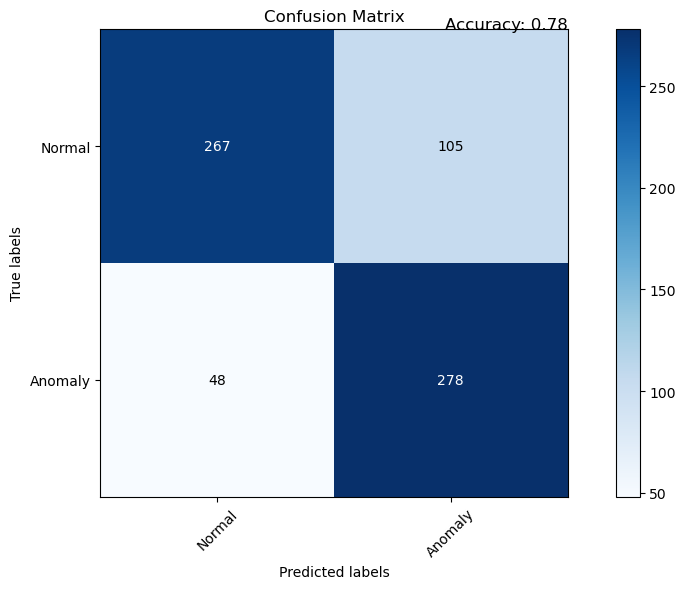

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Define class names
class_names = ['Normal', 'Anomaly']

# Calculate accuracy
accuracy = np.trace(conf_matrix) / float(np.sum(conf_matrix))

# Set the figure size
plt.figure(figsize=(10, 6))

# Plot confusion matrix
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Add counts to each cell
thresh = conf_matrix.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if conf_matrix[i, j] > thresh else "black")

# Add accuracy to the plot
plt.text(1.5, -0.5, f'Accuracy: {accuracy:.2f}', color='black', fontsize=12, horizontalalignment='right')

# Eliminate grid lines
plt.grid(False)

plt.tight_layout()
plt.show()


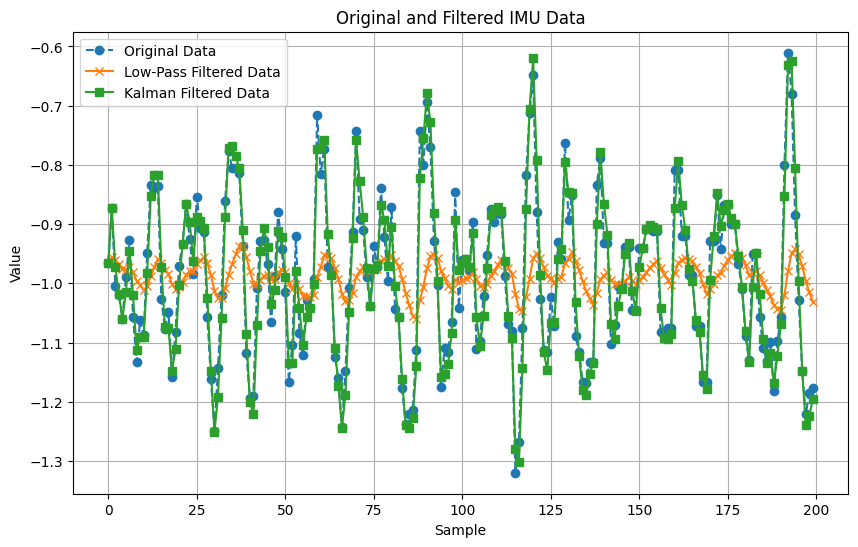

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import KalmanFilter

# Low-Pass Filter Class
class LowPassFilter:
    def __init__(self, alpha):
        self.alpha = alpha
        self.state = None

    def filter(self, value):
        if self.state is None:
            self.state = value
        else:
            self.state = self.alpha * value + (1 - self.alpha) * self.state
        return self.state

# Kalman Filter Function
def apply_kalman_filter(data, R, Q):
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([0., 0.])  # initial state (position and velocity)
    kf.F = np.array([[1., 1.],
                     [0., 1.]])  # state transition matrix
    kf.H = np.array([[1., 0.]])  # measurement function
    kf.P *= 1000.  # covariance matrix
    kf.R = R  # measurement noise
    kf.Q = Q  # process noise

    filtered_data = []

    for z in data:
        kf.predict()
        kf.update(z)
        filtered_data.append(kf.x[0])  # we are interested in the position

    return np.array(filtered_data)

# Example IMU data (numpy array)
imu_data = np.load('/home/iot/collision_detect/data/imu/normal_train/normal_5/85.npy')[:,-1][:1000]
# Apply Low-Pass Filter
lpf = LowPassFilter(alpha=0.1)
lpf_filtered_data = np.array([lpf.filter(value) for value in imu_data])

# Apply Kalman Filter
R = 0.1  # Example measurement noise
Q = 0.1  # Example process noise
kf_filtered_data = apply_kalman_filter(imu_data, R, Q)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(imu_data, label='Original Data', linestyle='--', marker='o')
plt.plot(lpf_filtered_data, label='Low-Pass Filtered Data', linestyle='-', marker='x')
plt.plot(kf_filtered_data, label='Kalman Filtered Data', linestyle='-', marker='s')

plt.title('Original and Filtered IMU Data')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


In [61]:
x = np.load('/home/iot/collision_detect/new_data/imu_np/Abnormal/fl/20.npy')[:,-1]
lpf = LowPassFilter(alpha=0.1)
lpf_filtered_data = np.array([lpf.filter(value) for value in x])

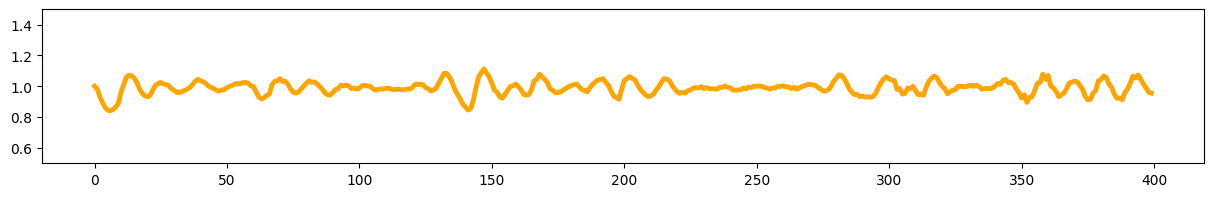

In [66]:
plt.figure(figsize=(15, 2))
plt.ylim(0.5,1.5)
plt.plot(lpf_filtered_data,color='orange',linewidth=3.5)

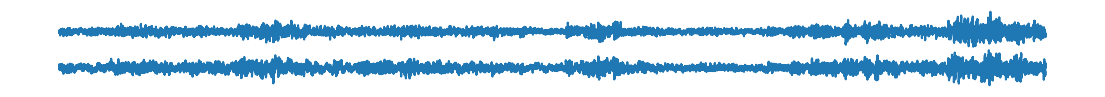

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Load the audio data
audio_data = np.load('/home/iot/collision_detect/new_data/audio_np/Abnormal/fl/20.npy')

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(14, 1))

# Plot the first audio signal
axs[0].plot(audio_data[0])
axs[0].axis('off')  # Turn off the axis
# axs[0].set_ylim(-0.1, 0.1) 
# Plot the second audio signal
axs[1].plot(audio_data[1])
axs[1].axis('off')  # Turn off the axis
# axs[1].set_ylim(-0.1, 0.1) 
# Adjust layout to have no space between plots
plt.subplots_adjust(hspace=0.001)

# Display the plot
plt.show()
